<a href="https://colab.research.google.com/github/VinayKanakeri/STN_NNFL/blob/master/STN_NNFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the reository to your drive, and pull the files. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Projects/NNFL/STN_NNFL
!git clone 'https://github.com/VinayKanakeri/STN_NNFL.git'
! git pull


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Projects/NNFL/STN_NNFL
fatal: destination path 'STN_NNFL' already exists and is not an empty directory.
Already up to date.


Print all the cloned files.

In [2]:
ls

augmentation.py        model.py      samplerNinterpolation.py  STN.png
Costs_wo_drop_reg.png  __pycache__/  STN_NNFL/                 utils.py
mnist_keras_load.py    README.md     STN_NNFL.ipynb


Import these libraries.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import math
!pip install tensorlayer

Run these python files.

In [4]:
%matplotlib inline 
%run mnist_keras_load.py
%run augmentation.py
%run utils.py
%run model.py
%run samplerNinterpolation.py

Using TensorFlow backend.


Import the required functions. 

In [0]:
from augmentation import aug_data
from mnist_keras_load import starter
from model import STN_Model
from samplerNinterpolation import sample_interpolate
from utils import get_initial_weights, random_mini_batches, append_shuffle

Load the dataset and augment it. Random rotation, scale, shift, and shear is applied for augmenting.

In [6]:
train_x, train_label, val_x, val_label, test_x, test_label = starter()
train_data,val_data,test_data = aug_data(train_x,val_x,test_x)

(60000, 10)
(10000, 10)


Use the following function to visualize randomly picked images with their labels.

In [0]:
def plot_imagesNlabels(data, labels,fname):
	rand_mine = np.random.randint(0,data.shape[0],12)
	sampled_x = data[rand_mine]
	sampled_y = labels[rand_mine].reshape(12,10)
	num_rows = 2
	num_cols = 6
	f, ax = plt.subplots(num_rows, num_cols, figsize = (12,5), gridspec_kw = {'wspace':0.03 , 'hspace':0.01}, squeeze = True)
	for i in range (num_rows):
		for j in range (num_cols):
			image_index = i*6 + j
			ax[i,j].axis("off")
			ax[i,j].imshow(np.squeeze(sampled_x[image_index]), cmap='gray')
			ax[i,j].set_title('No. %d' % np.where(sampled_y[image_index] == 1))
	f.savefig(fname)
	plt.show()

Now let us check the original dataset and augmented data.

Original dataset:



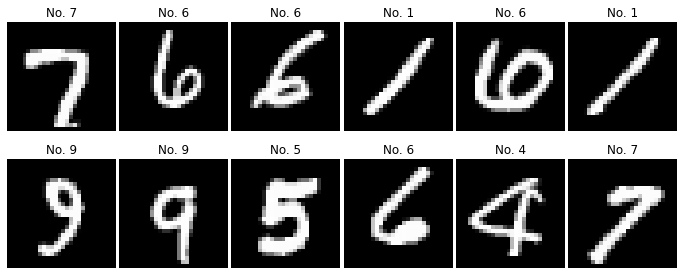

Augmented data:



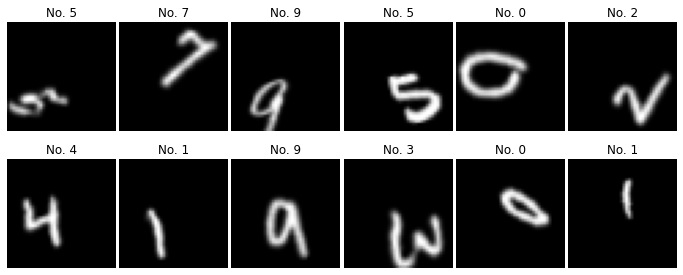

In [8]:
print("Original dataset:\n")
plot_imagesNlabels(train_x,train_label,"orig_images")
print("Augmented data:\n")
plot_imagesNlabels(train_data,train_label,"augmented_images")

Get the shape of input images and number of classes


In [9]:
train_data_1 = train_data[:,:,:,np.newaxis]
val_data_1 = val_data[:,:,:,np.newaxis]
test_data_1 = test_data[:,:,:,np.newaxis]
input_shape = train_data_1[0].shape
num_classes = train_label.shape[1]
print("Input shape: ",input_shape)
print("classes: ",num_classes)

Input shape:  (40, 40, 1)
classes:  10


Let us load the model and print the summary of our model.

In [10]:
model = STN_Model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
STN_Input (InputLayer)          [(None, 40, 40, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 38, 38, 16)   160         STN_Input[0][0]                  
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 19, 19, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 8)    2056        max_pooling2d[0][0]              
______________________________________________________________________________________________

Run the following code to plot the model:

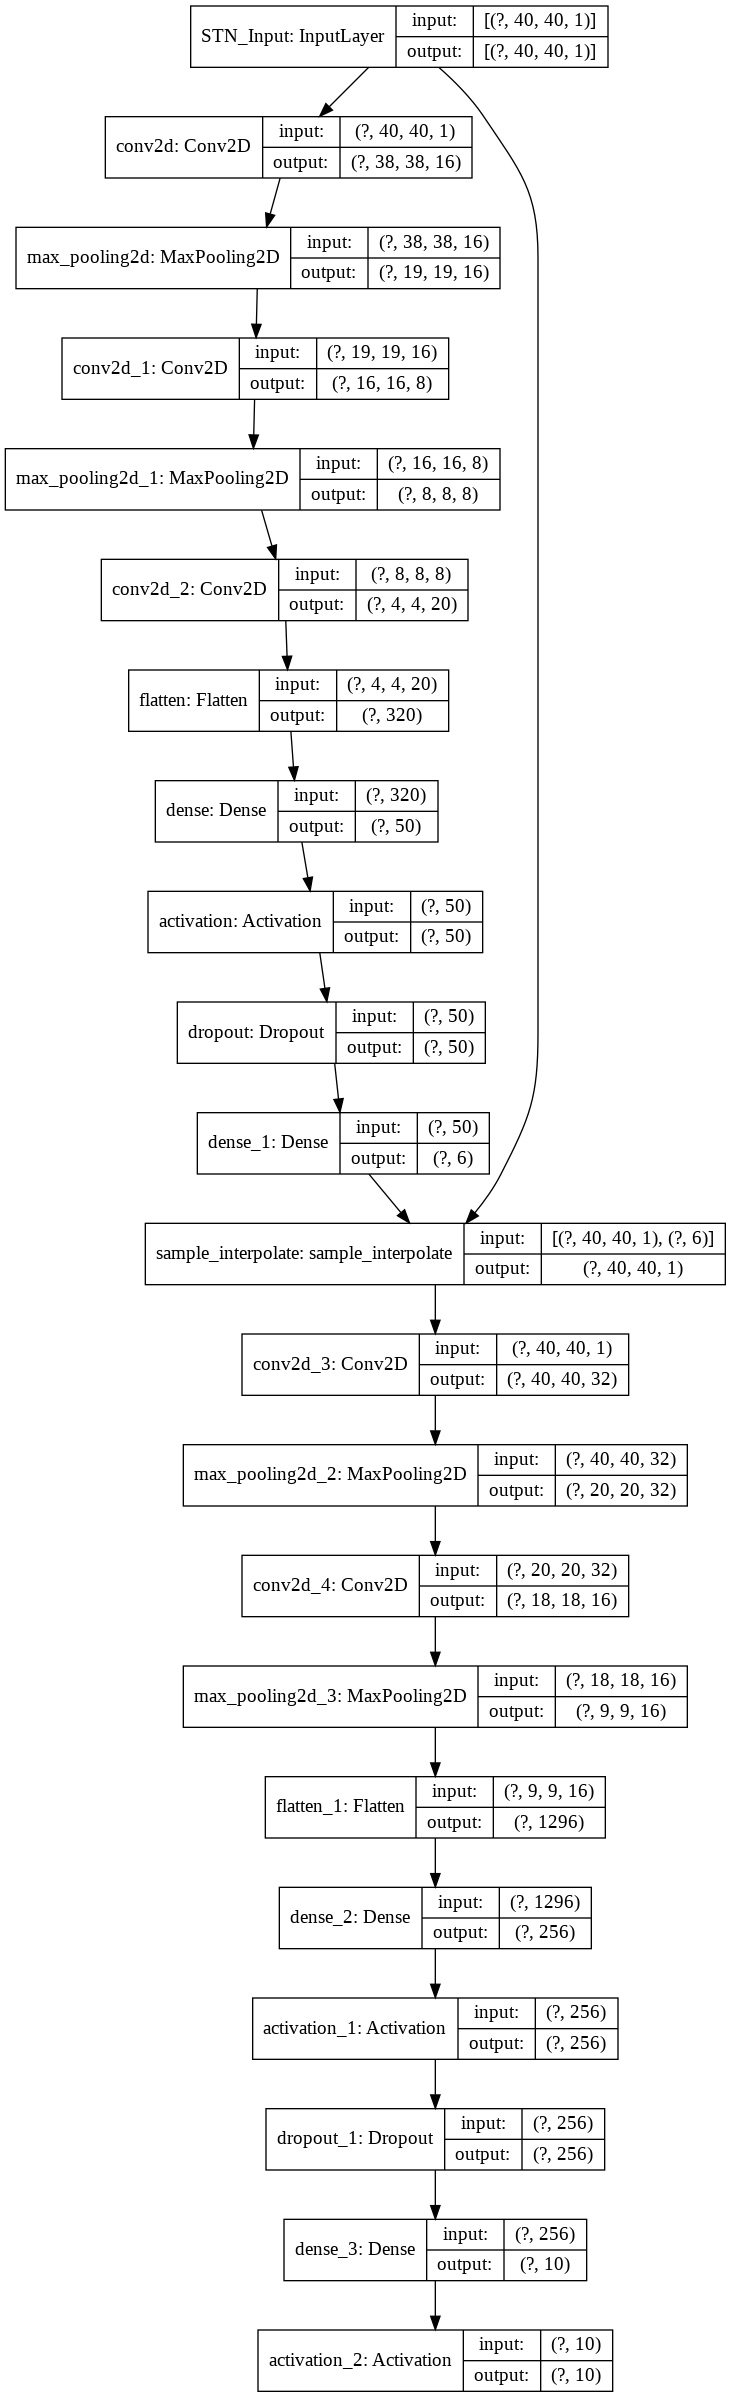

In [11]:
keras.utils.plot_model(model, 'STN.png', show_shapes=True)

Let us define a function to perform learning rate decay

In [0]:
def learning_decay(base_learning_rate, epoch_num, decay_rate):
  learning = []
  learning_rate = base_learning_rate/(1+(decay_rate*epoch_num))
  learning.append(learning_rate)
  return learning_rate

The following funtion trains and prints the results:

In [0]:
def train_STN(input_shape, num_classes, base_learning_rate=1e-2, batch_size = 64, num_epochs = 100, decay_rate = 0.09, l2_reg = 0.00, drop_rate = 0.00, print_steps = 200, print_freq = 1):
  # Call the model with parameters
  stn_model = STN_Model(input_shape=input_shape, num_classes=num_classes, reg=l2_reg, drop_rate=drop_rate)
  # define intermediate model to visualize the transformation
  stn_model.layers[11]._name='sample_interpolate'
  layer_output=stn_model.get_layer('sample_interpolate').output
  intermediate_model=tf.keras.models.Model(inputs=stn_model.input,outputs=layer_output)
  #define metrics
  train_acc_metric = keras.metrics.CategoricalAccuracy()
  val_acc_metric = keras.metrics.CategoricalAccuracy()

  batch_size = batch_size
  train_dataset = tf.data.Dataset.from_tensor_slices((train_data_1, train_label))
  train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

  #prepare val dataset
  val_dataset = tf.data.Dataset.from_tensor_slices((val_data_1, val_label))
  val_dataset = val_dataset.batch(64)
  costs = []
  costs_val = []
  epochs = num_epochs
  for epoch in range(epochs):
    learning_rate = learning_decay(base_learning_rate, epoch, decay_rate)
    # Instantiate an optimizer.
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    # Instantiate a loss function.
    loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
    epoch_cost = 0
    print('Start of epoch %d' % (epoch,))
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
      #gradient tape records forward pass allowing the optimizer to perform back propagation
      with tf.GradientTape() as tape:
        #logits contain predicted value (output)
        logits = stn_model(x_batch_train, training=True)
        loss_value = loss_fn(y_batch_train, logits)
        epoch_cost += loss_value
      #retrieve the gradients
      grads = tape.gradient(loss_value, stn_model.trainable_weights)
      #update the weights and biases
      optimizer.apply_gradients(zip(grads, stn_model.trainable_weights))
      train_acc_metric.update_state(y_batch_train, logits)
      if step % print_steps == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print('Training acc over epoch %i: %s' % (epoch, float(train_acc),))
    print ("Training Cost after epoch %i: %f" % (epoch, (epoch_cost*batch_size/(train_data_1.shape[0]))))
    #store the training costs over the epochs
    costs.append(epoch_cost*batch_size/(train_data_1.shape[0]))
    #print the output of transform layer
    if epoch % print_freq == 0:
      intermediate_prediction=intermediate_model.predict(train_data_1)
      print('Inputs after transformation after epoch %i :\n' % epoch)
      plot_imagesNlabels(intermediate_prediction,train_label, fname = "transformation" + str(epoch))

    

    
    val_cost = 0
    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
      val_logits = stn_model(x_batch_val)
      val_loss = loss_fn(y_batch_val, val_logits)
      val_cost += val_loss
      # Update val metrics
      val_acc_metric.update_state(y_batch_val, val_logits)
    #store the validation costs over the epochs
    costs_val.append(val_cost*64/(val_data_1.shape[0]))
    val_acc = val_acc_metric.result()
    
    print('Validation acc over epoch %i: %s' % (epoch, float(val_acc),))
    print ("Validation Cost after epoch %i: %f" % (epoch, (val_cost*64/(val_data_1.shape[0]))))


  return stn_model, np.squeeze(costs), np.squeeze(costs_val)



Let us train our model

Start of epoch 0
Training loss (for one batch) at step 0: 2.3026375770568848
Seen so far: 256 samples
Training loss (for one batch) at step 100: 2.1628904342651367
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 2.040274143218994
Seen so far: 51456 samples
Training acc over epoch 0: 0.2729814946651459
Cost after epoch 0: 2.171673
Inputs after transformation after epoch 0 :



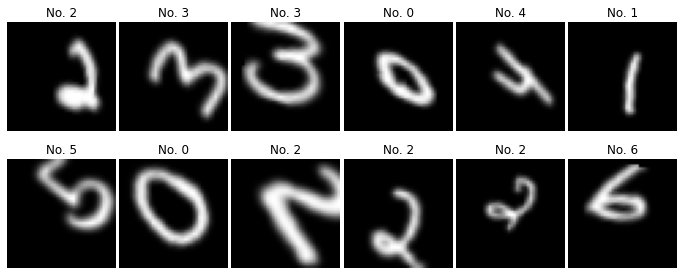

Validation acc over epoch 0: 0.4388333261013031
Cost after epoch 0: 2.026172
Start of epoch 1
Training loss (for one batch) at step 0: 2.026606321334839
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.8498626947402954
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.7789943218231201
Seen so far: 51456 samples
Training acc over epoch 1: 0.4348055422306061
Cost after epoch 1: 1.866374
Inputs after transformation after epoch 1 :



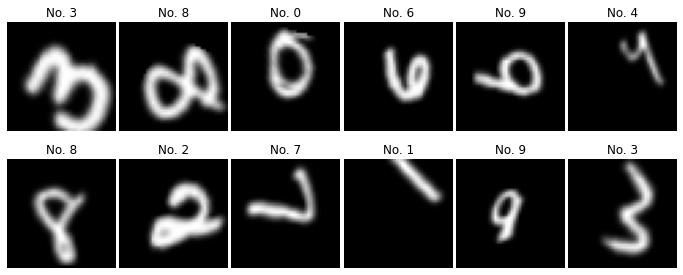

Validation acc over epoch 1: 0.5555833578109741
Cost after epoch 1: 1.795597
Start of epoch 2
Training loss (for one batch) at step 0: 1.8019330501556396
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.687652349472046
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.7313083410263062
Seen so far: 51456 samples
Training acc over epoch 2: 0.5312963128089905
Cost after epoch 2: 1.738329
Inputs after transformation after epoch 2 :



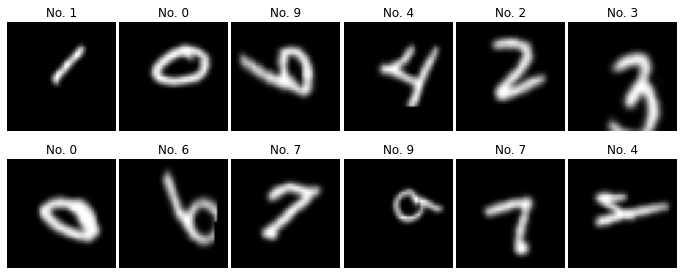

Validation acc over epoch 2: 0.6235555410385132
Cost after epoch 2: 1.708308
Start of epoch 3
Training loss (for one batch) at step 0: 1.7148034572601318
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6690897941589355
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6214547157287598
Seen so far: 51456 samples
Training acc over epoch 3: 0.5954397916793823
Cost after epoch 3: 1.673822
Inputs after transformation after epoch 3 :



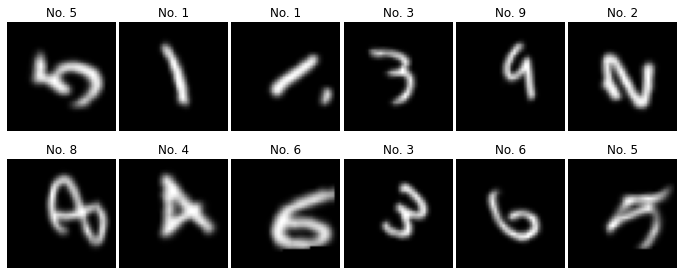

Validation acc over epoch 3: 0.6700833439826965
Cost after epoch 3: 1.656746
Start of epoch 4
Training loss (for one batch) at step 0: 1.6524302959442139
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6212440729141235
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.7280369997024536
Seen so far: 51456 samples
Training acc over epoch 4: 0.6404111385345459
Cost after epoch 4: 1.640988
Inputs after transformation after epoch 4 :



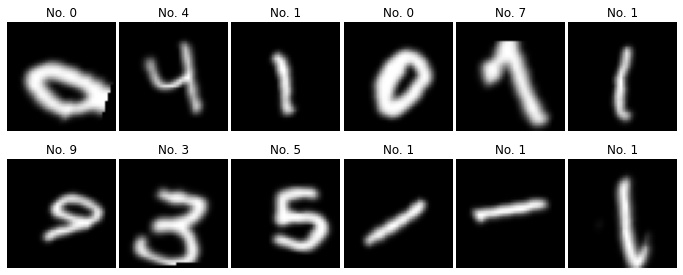

Validation acc over epoch 4: 0.6936333179473877
Cost after epoch 4: 1.677828
Start of epoch 5
Training loss (for one batch) at step 0: 1.7211312055587769
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6739630699157715
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6556384563446045
Seen so far: 51456 samples
Training acc over epoch 5: 0.6725925803184509
Cost after epoch 5: 1.627777
Inputs after transformation after epoch 5 :



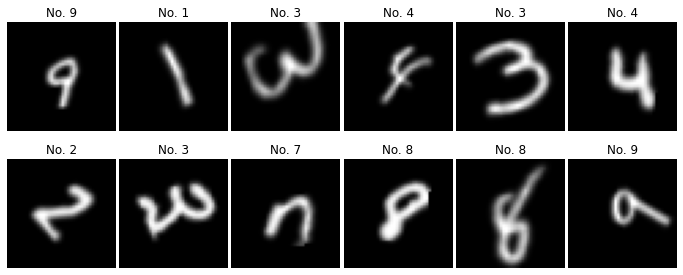

Validation acc over epoch 5: 0.7156111001968384
Cost after epoch 5: 1.639270
Start of epoch 6
Training loss (for one batch) at step 0: 1.6435527801513672
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6706901788711548
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5798530578613281
Seen so far: 51456 samples
Training acc over epoch 6: 0.6984232664108276
Cost after epoch 6: 1.607931
Inputs after transformation after epoch 6 :



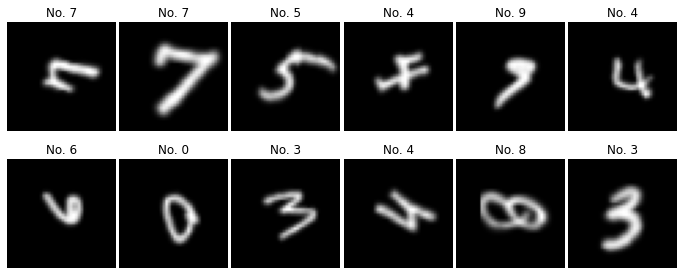

Validation acc over epoch 6: 0.735880970954895
Cost after epoch 6: 1.608189
Start of epoch 7
Training loss (for one batch) at step 0: 1.5851657390594482
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5994348526000977
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5698890686035156
Seen so far: 51456 samples
Training acc over epoch 7: 0.718925952911377
Cost after epoch 7: 1.598951
Inputs after transformation after epoch 7 :



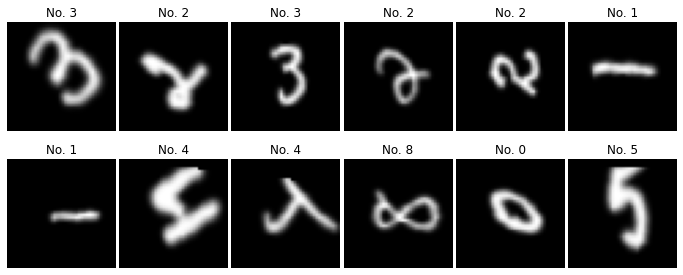

Validation acc over epoch 7: 0.749875009059906
Cost after epoch 7: 1.617753
Start of epoch 8
Training loss (for one batch) at step 0: 1.6365129947662354
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5819005966186523
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5908548831939697
Seen so far: 51456 samples
Training acc over epoch 8: 0.7360761165618896
Cost after epoch 8: 1.587969
Inputs after transformation after epoch 8 :



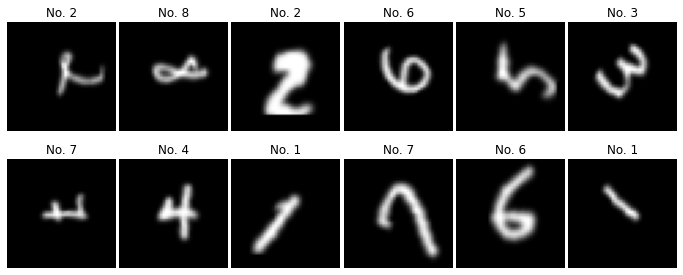

Validation acc over epoch 8: 0.7626851797103882
Cost after epoch 8: 1.601055
Start of epoch 9
Training loss (for one batch) at step 0: 1.5816385746002197
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6053177118301392
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5559757947921753
Seen so far: 51456 samples
Training acc over epoch 9: 0.7504055500030518
Cost after epoch 9: 1.582085
Inputs after transformation after epoch 9 :



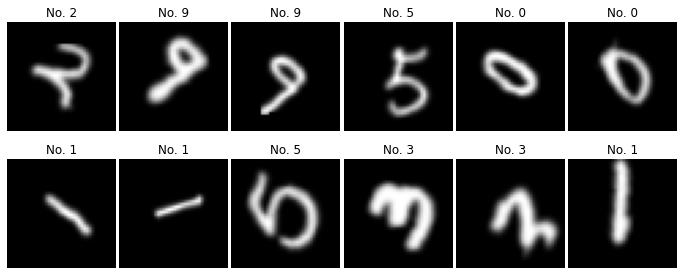

Validation acc over epoch 9: 0.7737166881561279
Cost after epoch 9: 1.591912


In [14]:
stn_model,train_cost,val_cost = train_STN(input_shape = input_shape, num_classes = num_classes, base_learning_rate=1e-2, batch_size = 256, num_epochs = 10, decay_rate = 0.09, l2_reg = 0.00, drop_rate = 0.00, print_steps = 100, print_freq = 1)

The following function plots train and validation costs

In [0]:
def plot_costs(num_epochs, train_cost, val_cost):
  # plot the training cost
  x = np.arange(0, num_epochs, 1)
  fig, ax = plt.subplots()
  ax.plot(x, train_cost, 'b', label='train cost')
  ax.plot(x, val_cost, 'r', label='validation cost')
  leg = ax.legend()
  plt.ylabel('cost')
  plt.xlabel('epochs')
  plt.title("Training and validation cost")
  fig.savefig('Costs_wo_drop_reg.png')
  plt.show()

  # plot the val cost
  #plt.plot(np.squeeze(costs_val))
  #plt.ylabel('cost')
  #plt.xlabel('epochs')
  #plt.title("Validation cost")
  #plt.show()

Lets plot the costs for the model trained without dropout and regularization

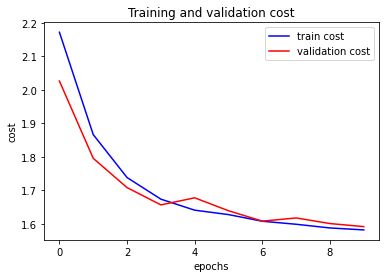

In [16]:
plot_costs(10,train_cost,val_cost)

In [17]:
ls

augmentation.py        samplerNinterpolation.py  transformation4.png
augmented_images.png   STN_NNFL/                 transformation5.png
Costs_wo_drop_reg.png  STN_NNFL.ipynb            transformation6.png
mnist_keras_load.py    STN.png                   transformation7.png
model.py               transformation0.png       transformation8.png
orig_images.png        transformation1.png       transformation9.png
__pycache__/           transformation2.png       utils.py
README.md              transformation3.png
